In [16]:
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from torch.utils.data import Dataset, DataLoader, Subset
import torchaudio.datasets as datasets
from torchaudio.transforms import RNNTLoss
import matplotlib.pyplot as plt
from torchaudio.functional import rnnt_loss
import os
import glob
import pickle as pkl
from LM.tokenizer.BPE import tokenize, tokenizer

from AudioModel import ConformerEncoder, CTCConformer
from dataset_SpecAugment import MyPipeline, LibriSpeechAugmented
import wandb
from tqdm import tqdm

### Creating Dataloader for training

#### loading tokeniser

In [17]:
current_dir = os.getcwd()

merges_path = os.path.join(current_dir, "LM\\tokenizer", "merges.pkl")
vocab_path = os.path.join(current_dir, "LM\\tokenizer", "vocabulary.pkl")

# Загрузка merges.pkl
with open(merges_path, "rb") as f:
    merges = pkl.load(f)
    print("Загрузка merges.pkl успешна")

# Загрузка vocab.pkl
with open(vocab_path, "rb") as f:
    vocab = pkl.load(f)
    print("Загрузка vocabulary.pkl успешна")

#vocab[0] = '<|blank|>'
#vocab[1] = '<|padding|>'
#vocab[2] = '<|startoftext|>'
vocab[1] = '<|blank|>'

token_to_id = {vocab[i]: i for i in range(len(vocab))}
id_to_token = {i: vocab[i] for i in range(len(vocab))}
PAD_ID = 2
BLANK_ID = 1
START_ID = 0
print(vocab)

Загрузка merges.pkl успешна
Загрузка vocabulary.pkl успешна
['<|startoftext|>', '<|blank|>', '<|padding|>', "'", 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'Ġ', 'ĠT', 'HE', 'ĠA', 'IN', 'ĠTHE', 'ĠW', 'ĠS', 'ĠO', 'RE', 'ND', 'ĠH', 'ER', 'ĠB', 'ĠM', 'OU', 'IT', 'ĠF', 'IS', 'ĠC', 'AT', 'ED', 'ĠAND', 'ĠOF', 'EN', 'ON', 'ING', 'ĠTO', 'ĠP', 'OR', 'ES', 'ĠD', 'ĠTH', 'ĠL', 'AN', 'AS', 'ĠIN', 'AR', 'LL', 'ĠN', 'ĠHE', 'ĠG', 'AD', 'LE', 'OM', 'ĠE', 'ĠBE', 'OT', 'UT', 'IC', 'OW', 'LY', 'SE', 'ĠI', 'ST', 'VE', 'ĠWAS', 'LD', 'ĠWH', 'GH', 'ĠIT', 'ĠTHAT', 'ĠON', 'ĠU', 'ENT', 'AL', 'THE', 'ID', 'IM', 'VER', 'ĠHIS', 'ĠY', 'ĠRE', 'IR', 'ITH', 'CE', 'ION', 'ĠR', 'ĠWITH', 'ĠWE', 'ET', 'ĠAS', 'ĠFOR', 'AY', 'ĠST', 'UR', 'ĠHAD', 'GHT', 'ĠYOU', 'OO', 'ĠNOT', 'TER', 'ĠAN', 'AND', 'AC', 'ĠIS', 'ĠAT', 'ĠSE']


#### Parsing librispeech

Total num of .flac: 2703
Max len and min len of .flac (sec * 16000) 522320 23120


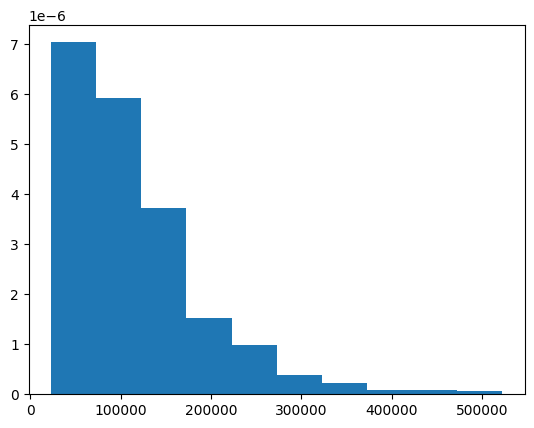

In [18]:
data = datasets.LIBRISPEECH("data", url="dev-clean",)
samples = []
lens = []
corpus = []
for i in range(2800):
    try:
        samples.append(data.__getitem__(i))
        lens.append(data.__getitem__(i)[0].shape[1])
        corpus.append(list(map(lambda x: token_to_id[x], [vocab[START_ID]] + tokenize(data.__getitem__(i)[2], merges))))
    except IndexError as err:
        break

num = len(samples)

print("Total num of .flac:", num)
print("Max len and min len of .flac (sec * 16000)", max(lens), min(lens))
plt.hist(lens, density=True)
plt.show()
arr = np.array(lens)

In [19]:
wandb.init(project='ConformerCTC')
config = {
    'depthwise_conv_kernel_size':3,
    'num_heads':8,
    'num_conformers':4,
    'mask_ratio':0.05,
    'distraction_ratio':0.05,
    'learning_rate': 0.01,
    'batch_size': 32,
    'epochs': 128,
    'input_dim': 128,
    'embedding_dim': 64,
    'temperature':0.5,
    'dataset': "LibriSpeech dev-clean",
    'vocab_size': len(vocab),
    'decoder_dim': 64,
    'weight_decay': 1e-5,
}
#torch.autograd.set_detect_anomaly(True)
wandb.config.update(config)

#### Creating Dataset

In [20]:
augmentation = MyPipeline(n_mel=config['input_dim'],)

max_length = max(len(seq) for seq in corpus)

class MixedDataset(Dataset):
    def __init__(self, audio_dataset: Dataset, text_corpus: list, max_len: int):
        self.audio_dataset = audio_dataset
        self.text_corpus = text_corpus
        self.max_len = max_len

    def __len__(self):
        return len(self.text_corpus)

    def __getitem__(self, idx):
        sample = torch.tensor(self.text_corpus[idx], dtype=torch.int16)
        sample = sample[:self.max_len]
        length = sample.shape[-1]
        padding = torch.ones((self.max_len - sample.shape[-1])) * PAD_ID
        sample = torch.cat((sample, padding), dim=0)
        return *self.audio_dataset.__getitem__(idx), torch.tensor(sample, dtype=torch.float), length

audio_dataset = LibriSpeechAugmented("data",
                               url="dev-clean",
                               augmentations=augmentation,
                               max_length=int(arr.mean()
                                              + arr.std() * 3
                                              ),
                               n_mel=config['input_dim']
                               )
print(audio_dataset.__getitem__(0)[0].shape)
dataset = MixedDataset(audio_dataset, corpus, max_length)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=config["batch_size"],shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config["batch_size"])

torch.Size([663, 128])


In [21]:
for i, x in enumerate(train_loader):
    if i > 1:
        break
    x, x_length, y, y_length = x
    print(x_length.shape)
    #print(y)

C:\Users\User\AppData\Local\Temp\ipykernel_201916\2359739168.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return *self.audio_dataset.__getitem__(idx), torch.tensor(sample, dtype=torch.float), length


torch.Size([32])
torch.Size([32])


### Model constructing

In [22]:
modelEnc = ConformerEncoder(input_dim=config["input_dim"],
                embed_dim=config['embedding_dim'],
                ffn_dim=config['embedding_dim'],
                depthwise_conv_kernel_size=config['depthwise_conv_kernel_size'],
                num_heads=config['num_heads'],
                num_layers=config['num_conformers'],
                )
print(modelEnc)

ConformerEncoder(
  (subsample): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (linear_layer): Linear(in_features=64, out_features=64, bias=True)
  (conformer): Conformer(
    (conformer_layers): ModuleList(
      (0-3): 4 x ConformerLayer(
        (ffn1): _FeedForwardModule(
          (sequential): Sequential(
            (0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            (1): Linear(in_features=64, out_features=64, bias=True)
            (2): SiLU()
            (3): Dropout(p=0.1, inplace=False)
            (4): Linear(in_features=64, out_features=64, bias=True)
            (5): Dropout(p=0.1, inplace=False)
          )
        )
        (self_attn_layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (self_attn_dropout): Dropout(p=0.1, inplace=False)
        (conv_module): _Convolu

In [23]:
model_pattern = os.path.join("best_models/wav2vec", "NewModel2.pt")
model_files = glob.glob(model_pattern)

if not model_files:
    raise FileNotFoundError(f"Файл не найден по шаблону: {model_pattern}")

model_path = model_files[0]
pretrained_state_dict = torch.load(model_path, map_location='cpu')
print(pretrained_state_dict)

OrderedDict({'subsample.weight': tensor([[[-3.4309e-02,  8.4253e-02,  4.4327e-02],
         [-4.1183e-03,  3.4762e-02, -2.5742e-03],
         [-3.4172e-03,  5.0016e-02, -4.5765e-02],
         ...,
         [-3.1477e-02, -7.8688e-03, -2.9575e-02],
         [ 1.6558e-02,  2.9175e-02,  3.5580e-02],
         [ 2.2803e-03,  5.3495e-03,  6.8512e-03]],

        [[ 1.4353e-02,  3.8045e-02,  4.6188e-02],
         [ 5.9606e-02,  6.6358e-03,  1.2029e-02],
         [-5.9210e-04,  3.2745e-02,  3.1200e-02],
         ...,
         [ 1.1051e-02, -1.4398e-02, -4.8170e-02],
         [ 1.3437e-02, -2.2341e-03,  4.2600e-02],
         [ 5.3669e-02,  1.4233e-02, -1.7504e-03]],

        [[ 9.6066e-02,  1.1996e-01,  4.0374e-02],
         [ 1.0636e-01,  1.3368e-01,  8.6270e-02],
         [ 4.8852e-02,  1.1746e-01,  1.5630e-02],
         ...,
         [ 2.6102e-02, -1.7559e-02,  6.1717e-02],
         [ 4.4245e-02,  1.0635e-02,  4.2612e-02],
         [ 3.1040e-02,  9.5259e-02,  3.2671e-02]],

        ...,

     

In [24]:
del pretrained_state_dict['target_encoder.weight']
del pretrained_state_dict['target_encoder.bias']
modelEnc.load_state_dict(pretrained_state_dict, strict=False)

<All keys matched successfully>

In [25]:
model = CTCConformer(modelEnc, config["vocab_size"])

In [26]:
model_path = os.path.join("best_models/conformerctc", "best_model_2.7741.pt")
pretrained_state_dict = torch.load(model_path, map_location='cpu')
model.load_state_dict(pretrained_state_dict)

<All keys matched successfully>

### Prerequisites

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])
criterion = torch.nn.CTCLoss(blank=BLANK_ID)

In [28]:
def validate(model, dataloader, criterion, device, blank_id=0):
    model.eval()
    total_loss = 0.0
    total_items = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validation"):
            x, x_lengths, y, y_lengths = batch
            x = x.to(device)
            y = y.to(device)
            x_len = x_lengths.to(device)
            y_len = y_lengths.to(device)

            # Forward pass
            logits = model(x, x_len)  # ConformerCTC возвращает (logits, lengths)
            log_probs = torch.log_softmax(logits, dim=-1)  # [B, T, vocab_size]

            # CTC Loss требует [T, B, vocab_size]
            loss = criterion(
                log_probs.transpose(0, 1),  # [T, B, vocab_size]
                y,                        # [B, U]
                x_len,                    # [B]
                y_len                     # [B]
            )

            total_loss += loss.item() * x.size(0)
            total_items += x.size(0)

    return total_loss / total_items


def train(model, train_loader, val_loader, criterion, optimizer, device, config):
    best_loss = float("inf")
    patience = config.get("patience", 10)
    no_improve_epochs = 0

    for epoch in range(config["epochs"]):
        model.train()
        epoch_loss = 0.0
        total_items = 0

        progress = tqdm(train_loader, desc=f"Epoch {epoch+1}")

        for batch in progress:
            x, x_len, y, y_len = batch
            x = x.to(device)
            y = y.to(device)
            x_len = x_len.to(device)
            y_len = y_len.to(device)

            assert not torch.isnan(x).any(), "NaN в аудиофичах!"
            assert not torch.isinf(x).any(), "Inf в аудиофичах!"
            assert (x_len > 0).all(), "Есть нулевые длины аудио!"
            assert (y_len > 0).all(), "Есть нулевые длины текста!"

            optimizer.zero_grad()

            logits = model(x, x_len)

            logits = torch.nan_to_num(logits, nan=0.0, posinf=1e8, neginf=-1e8)

            logits = torch.clamp(logits, min=-50, max=50)

            log_probs = logits - torch.logsumexp(logits, dim=-1, keepdim=True)

            assert not torch.isnan(log_probs).any(), "NaN после всех преобразований!"

            # CTC Loss calculation
            loss = criterion(
                log_probs.transpose(0, 1),  # [T, B, vocab_size]
                y,                        # [B, U]
                x_len,           # [B]
                y_len                     # [B]
            )

            if torch.isinf(loss):
                print(f"Обнаружен inf в лоссе (значение: {loss.item()}), пропускаем батч")
                continue

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            epoch_loss += loss.item() * x.size(0)
            total_items += x.size(0)
            progress.set_postfix({"loss": loss.item()})

        # Validation
        val_loss = validate(model, val_loader, criterion, device)
        avg_train_loss = epoch_loss / total_items

        # Logging
        wandb.log({
            "epoch": epoch+1,
            "train_loss": avg_train_loss,
            "val_loss": val_loss
        })

        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f}")

        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            no_improve_epochs = 0
            torch.save(model.state_dict(), f"best_model_{val_loss:.4f}.pt")
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= patience:
                print(f"Early stopping triggered after {patience} epochs without improvement.")
                break

    wandb.finish()

### Training

In [29]:
train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    config=config
)

Epoch 1:   0%|          | 0/76 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_201916\2359739168.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return *self.audio_dataset.__getitem__(idx), torch.tensor(sample, dtype=torch.float), length
Validation: 100%|██████████| 9/9 [00:01<00:00,  6.19it/s]


Epoch 1 | Train Loss: 4.6991 | Val Loss: 4.1471


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.12it/s]


Epoch 2 | Train Loss: 4.0596 | Val Loss: 3.9177


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.77it/s]


Epoch 3 | Train Loss: 3.8762 | Val Loss: 3.8061


Epoch 4:  24%|██▎       | 18/76 [00:04<00:14,  3.91it/s, loss=3.86]


KeyboardInterrupt: 

In [15]:
torch.save(model.state_dict(), f"best_models/conformerctc/best_CTC_Conf_268.pt")